# Deep Convolutional Generative Adversarial Network



L'objectif de ce TP est d'explorer la fascinante génération d'images de chiffres manuscrits en utilisant un réseau DCGAN (Deep Convolutional Generative Adversarial Network). Cette approche révolutionnaire nous permettra de créer des images qui semblent authentiques, avec l'apparence de chiffres écrits à la main.

Grâce à l'utilisation du réseau DCGAN, nous pourrons entraîner un modèle qui génère des images de chiffres réalistes à partir de bruit aléatoire. Ce processus implique deux parties essentielles: le générateur, qui crée de nouvelles images à partir du bruit, et le discriminateur, qui évalue la qualité de ces images en les comparant à des images réelles.

In [ ]:

!pip install imageio
!pip install git+https://github.com/tensorflow/docs

# Importe les bibliothèques nécessaires

In [29]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

# On charge les données du jeu de données MNIST

In [30]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Le code ci-dessous prétraite les images d'entraînement du jeu de données MNIST.

### 1- Redimensionner les images en 28x28 pixels.
### 2- Convertir les images en format float32.
### 3- Normaliser les images en les centrant autour de 0 et en les mettant à l'échelle entre -1 et 1.

In [31]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [33]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Création du modèle


# Le générateur

Le modèle générateur est un réseau de neurones convolutifs transposés qui prend un vecteur de bruit aléatoire en entrée et génère une image de 28x28 pixels en sortie.

Le modèle est composé de plusieurs couches :

In [34]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Une couche dense qui convertit le vecteur de bruit aléatoire en une matrice de 7x7x256.
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    # Une couche de normalisation par lots.
    model.add(layers.BatchNormalization())
    # Une couche d'activation ReLU qui applique une fonction d'activation ReLU à chaque élément de la matrice.
    model.add(layers.LeakyReLU())

    # Une couche de reshape qui convertit la matrice en un tenseur de 7x7x256.
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    # Une couche de convolution transposée qui augmente la taille de la matrice à 14x14x128.
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)

    # Une couche de normalisation par lots.
    model.add(layers.BatchNormalization())

    #Une couche d'activation ReLU qui applique une fonction d'activation ReLU à chaque élément de la matrice.
    model.add(layers.LeakyReLU())

    # Une couche de convolution transposée qui augmente la taille de la matrice à 28x28x64.
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)

    # Une couche de normalisation par lots.
    model.add(layers.BatchNormalization())
    # Une couche d'activation ReLU qui applique une fonction d'activation ReLU à chaque élément de la matrice.
    model.add(layers.LeakyReLU())

    # Une couche de convolution transposée qui génère l'image de sortie de 28x28 pixels.
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)


    # La fonction make_generator_model() renvoie le modèle générateur.
    return model

Le code ci-dessous génère une image à partir d'un modèle générateur.

Le modèle générateur est créé à l'aide de la fonction make_generator_model().

Une fois le modèle générateur créé, il est utilisé pour générer une image à partir d'un vecteur de bruit aléatoire.

Le vecteur de bruit aléatoire est créé à l'aide de la fonction tf.random.normal().

L'image générée est affichée à l'aide de la fonction plt.imshow().

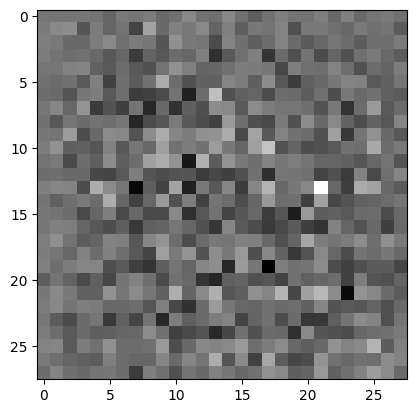

In [35]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# Le discriminateur

Le modèle discriminateur est un réseau de neurones convolutifs qui prend une image en entrée et renvoie une valeur de probabilité entre 0 et 1. Cette valeur de probabilité indique la probabilité que l'image soit une vraie image ou une image générée par le modèle générateur.

Le modèle est composé de plusieurs couches :

In [36]:
def make_discriminator_model():
    model = tf.keras.Sequential()


    # Une couche de convolution qui réduit la taille de l'image à 14x14x64
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    # Une couche d'activation ReLU qui applique une fonction d'activation ReLU à chaque élément de la matrice.
    model.add(layers.LeakyReLU())

    # Une couche de dropout qui supprime aléatoirement 30 % des éléments de la matrice.
    model.add(layers.Dropout(0.3))

    # Une couche de convolution qui réduit la taille de l'image à 7x7x128.
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))

    # Une couche d'activation ReLU qui applique une fonction d'activation ReLU à chaque élément de la matrice.
    model.add(layers.LeakyReLU())

    # Une couche de dropout qui supprime aléatoirement 30 % des éléments de la matrice.
    model.add(layers.Dropout(0.3))

    # Une couche de flattening qui convertit la matrice en un vecteur.
    model.add(layers.Flatten())

    # Une couche dense qui renvoie une valeur de probabilité entre 0 et 1.
    model.add(layers.Dense(1))

    # La fonction make_discriminator_model() renvoie le modèle discriminateur.
    return model

le modèle discriminateur pour prédire la probabilité que l'image générée soit une vraie image ou une image générée par le modèle générateur.

In [37]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00180411]], shape=(1, 1), dtype=float32)


Définition des fonctions de perte

Les fonctions de perte sont utilisées pour mesurer la performance du modèle. Dans ce cas, nous utilisons deux fonctions de perte :

La fonction de perte du discriminateur mesure la capacité du discriminateur à distinguer les vraies images des images générées par le générateur.
La fonction de perte du générateur mesure la capacité du générateur à générer des images qui trompent le discriminateur.

In [38]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## La fonction de perte du discriminateur est définie comme suit :

In [39]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## La fonction de perte du générateur est définie comme suit :

In [40]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [41]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [43]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

La fonction train_step est une fonction d'entraînement qui prend un lot d'images en entrée et met à jour les poids du générateur et du discriminateur.



@tf.function indique à TensorFlow de compiler la fonction. Cela permet d'accélérer l'exécution de la fonction.

In [44]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

La fonction d'entraînement parcourt l'ensemble de données et met à jour les poids du générateur et du discriminateur à chaque itération.

La fonction d'entraînement génère également des images à chaque époque et les enregistre dans un fichier GIF.

In [45]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

La fonction generate_and_save_images() génère des images et les enregistre dans un fichier PNG.

In [46]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#  l'entraînement du modèle

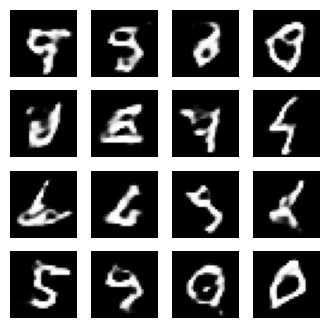

In [47]:
train(train_dataset, EPOCHS)

In [48]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [49]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

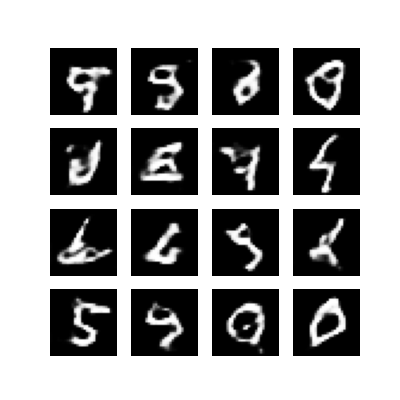

In [50]:
display_image(EPOCHS)

In [51]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-51-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-51-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



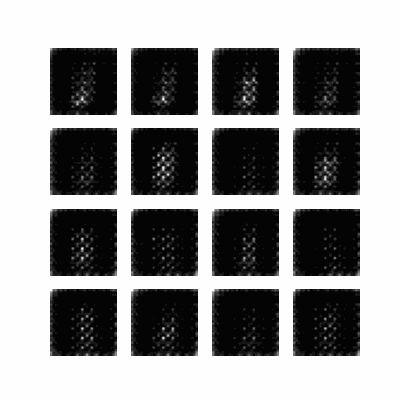

In [52]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Le modèle GAN que nous avons créé est capable de générer des images de chiffres manuscrits qui sont très réalistes. Nous pouvons utiliser ce modèle pour générer de nouvelles images de chiffres manuscrits, ou pour apprendre à un ordinateur à reconnaître des chiffres manuscrits.



